In this example workflow, we'll analyze a cross section containing two 345 kV circuits to predict the impact of changing one circuit to a "delta" configuration. We'll also look at potential field reductions through phase optimization and through adding height to the circuits. Because this is a relatively small modeling effort, we won't rely on `emf.fields` excel templates, but will build the model using only Python.

In [1]:
#import emf.fields, which simulates electric and magnetic fields along
#lines perpendicular to parallel sets of power lines
import emf.fields as fld
#special command for the notebook to show plots inline
%matplotlib inline 

First, we have to create `emf.fields` objects containing information about the power lines. We'll have 7 `Conductor` objects representing two 3-phase circuits with a single grounded line. The `Conductor` objects will go into two different `CrossSection` objects that represent the original configuration and the configuration with one circuit switched to a delta configuration. These two `CrossSections`, basically a before-after pair, will go into a top level `SectionBook` object for comparison, plotting, and exporting.

In [2]:
#create a Conductor object for the first power line in circuit 1, which will
#consist of three 345 kV lines, all at the same height, and a single ground wire

#fld.Conductor accepts up to three arguments to construct an object
#    1) the conductor  name
#    2) a dict of physical parameters or a properly ordered list (see the docs
#            for Conductor object initialization)
#    3) an existing Conductor. Paremeters that are not specified in the second
#       argument are copied from the existing conductor

#here we only pass two arguments to create the first Conductor object
c_1a = fld.Conductor('1a', dict(
        x=-25, #x coordinate in feet
        y=22, #y coordinate in feet
        subconds=1, #number of subconductors in the "bundle" (usually 1)
        d_cond=1.5, #diameter of conductor in inches
        d_bund=1.5, #diameter of conductor "bundle" in inches
        V=345, #phase-phase potential in volts
        I=600, #current in amps
        phase=0)) #phase angle in degrees

In [3]:
#create the other two conductors in circuit 1 by specifying certain parameters
#in the second argument, then copying all others from an existing Conductor
c_1b = fld.Conductor('1b', dict(x=-20, phase=120), c_1a)
c_1c = fld.Conductor('1c', dict(x=-15, phase=240), c_1b)

In [4]:
#now create the second circuit, which will be the same as the first,
#but with x coordinates reflected about x = 0
c_2a = fld.Conductor('2a', {'x': abs(c_1a.x)}, c_1a)
c_2b = fld.Conductor('2b', {'x': abs(c_1b.x)}, c_1b)
c_2c = fld.Conductor('2c', {'x': abs(c_1c.x)}, c_1c)

Now that we've created `Conductor` objects for each of the lines in our "before" model and our "after" model, we can put the `Conductor` objects into `CrossSection` objects, which will perform the desired EMF calculations. `Conductor` objects can be added to a `CrossSection` object upon initialization, as shown below.

In [5]:
#now the first CrossSection object can be created, containing the Conductor
#objects created above

#like the Conductor constructor, the CrossSection constructor requires the first
#argument to be the "sheet" or name of the new object. The second arg is simply
#a list of the Conductor objects to copy into the CrossSection
before = fld.CrossSection('before', [c_1a, c_1b, c_1c, c_2a, c_2b, c_2c])
#set some identification variables
before.group = 'Delta Test'
before.title = 'Before Delta Implementation'
#and set the sampling variables, which determine where emf values are calculated
before.max_dist = 50 #sample to 50 ft from the center of the xs
before.step = 0.5    #sample every half foot along the xs
before.lROW = -40    #left edge of power line right of way (ROW)
before.rROW = 40     #right ROW edge

#inspect the CrossSection by printing it
print(before)

  CrossSection object

    sheet:                         before
    parent SectionBook:            None
    group:                         Delta Test
    title:                         Before Delta Implementation
    soil resistivity (?):          100.0
    max distance from center (ft): 50.0
    step size (ft):                0.5
    sample height (ft):            3.0
    left ROW edge (ft):            -40.0
    right ROW edge (ft):           40.0

    conductor information (6 Conductors)
      names:                 '1a', '1b', '1c', '2a', '2b', '2c'
      frequencies (Hz):      60.0, 60.0, 60.0, 60.0, 60.0, 60.0
      x coordinates (ft):    -25.0, -20.0, -15.0, 25.0, 20.0, 15.0
      y coordinates (ft):    22.0, 22.0, 22.0, 22.0, 22.0, 22.0
      subconductors:         1.0, 1.0, 1.0, 1.0, 1.0, 1.0
      diameters (in):        1.5, 1.5, 1.5, 1.5, 1.5, 1.5
      bundle diameters (in): 1.5, 1.5, 1.5, 1.5, 1.5, 1.5
      voltages (V):          345.0, 345.0, 345.0, 345.0, 345.0, 345.0
 

In [6]:
#check that the CrossSection is complete, meaning all the necessary variables in
#its Conductor objects are set
print(before.complete)

(True, None)


In [7]:
#all set, now we'll copy and edit the "before" CrossSection to create the
#"after" version with the delta configuration
after = before.copy()
#Conductors in a CrossSection can be accessed by their name strings
after['2b'].y += 5
after['2c'].x = after['2a'].x
after['2c'].y = after['2a'].y + 10.0
#edit the after version's identification variables
after.sheet = 'after'
after.title = 'After Delta Implementation'

Finally, before looking at the numbers, we put the `CrossSection` objects into a top level `SectionBook` object, which is essential for comparing the `CrossSections`. The `CrossSection` objects can be added to a `SectionBook` object upon its initialization.

In [8]:
sb = fld.SectionBook('delta-test', [before, after])

But wait! We forgot the ground wire in circuit 1! Adding a `Conductor` to a `CrossSection` is easy with `add_conductor()`.

In [9]:
#create the grounded line by passing a list of parameters that correspond to:
# [x, y, subconds, d_cond, d_bund, V, I, phase]
ground = fld.Conductor('1g', [-17.5, 27.5, 1, 1, 1, 0, 0, 0])
#                                                   ^ zero voltage (grounded)

#add the ground line to the before and after xcs, which can be accessed
#by keying the SectionBook like a dict, using a CrossSection's
#sheet string as the key
sb['before'].add_conductor(ground)
sb['after'].add_conductor(ground)

On to the results... EMF calculations are performed by a `CrossSection` only when they need to be. If the `fields` attribute of a `CrossSection` is accessed and the fields haven't been calculated yet, the `CrossSection` will automatically calculate and store them. Then, if any of the relevant attributes of the `CrossSection` object's `Conductor`s are changed, even if EMF have already been calculated, the `CrossSection` will wipe the stored results and wait to recalculate EMF whenever its `fields` attribute is next accessed.

For example, if we access `fields` from the `before` `CrossSection`, it will calculate and store a DataFrame of EMF results, then return the DataFrame.

In [10]:
#the fields attribute leads to a Pandas DataFrame
print(sb['before'].fields.head(3))

                    Bmax      Bprod         Bx        By      Emax     Eprod  \
Distance (ft)                                                                  
-50.0          22.383021  22.394635  21.682692  5.601831  1.683781  1.683851   
-49.5          23.028616  23.041231  22.397989  5.406329  1.727492  1.727565   
-49.0          23.696805  23.710513  23.136263  5.186693  1.772186  1.772260   

                     Ex        Ey  
Distance (ft)                      
-50.0          0.256559  1.664191  
-49.5          0.262274  1.707540  
-49.0          0.267889  1.751896  


Now if we change information in one of the `Conductor` objects in the `CrossSection`, the DataFrame is cleared and will be repopulated the next time it's needed.

In [11]:
#Conductors can also be accessed by the order in which they were
#added to the CrossSection
sb['before'].i[0].V += 1000 #boost the Voltage!
sb['before']['1b'].I += 1000 #boost the Current!
print (sb['before'].fields.head(3))

                     Bmax       Bprod          Bx          By       Emax  \
Distance (ft)                                                              
-50.0          184.338265  184.975014   98.865314  156.337474  10.003151   
-49.5          186.573209  187.251314  101.277400  157.499025  10.249154   
-49.0          188.852940  189.575325  103.766759  158.654541  10.501329   

                   Eprod        Ex         Ey  
Distance (ft)                                  
-50.0          10.003167  1.444289   9.898352  
-49.5          10.249169  1.480245  10.141713  
-49.0          10.501345  1.516345  10.391291  


The fields were automatically recalculated when the `fields` property was accessed because we changed some of the variables in it's `Conductor` objects. We have some seriously high fields now... Let's change them back and make sure the fields will update again.

In [12]:
sb['before'].i[0].V -= 1000
sb['before']['1b'].I -= 1000
print(sb['before'].fields.head(3))

                    Bmax      Bprod         Bx        By      Emax     Eprod  \
Distance (ft)                                                                  
-50.0          22.383021  22.394635  21.682692  5.601831  1.683781  1.683851   
-49.5          23.028616  23.041231  22.397989  5.406329  1.727492  1.727565   
-49.0          23.696805  23.710513  23.136263  5.186693  1.772186  1.772260   

                     Ex        Ey  
Distance (ft)                      
-50.0          0.256559  1.664191  
-49.5          0.262274  1.707540  
-49.0          0.267889  1.751896  


Back to normal.

Now on to the analysis.

Let's take a look at how the magnetic fields compare between our before and after `CrossSections` by plotting them as a group. Groups of `CrossSection` objects within a `SectionBook` are defined by the `CrossSection` `group` attributes. `CrossSection` objects with identical groups are automatically grouped by the `SectionBook`. That's why we set the `group` attributes of both CrossSections to "Delta Test".

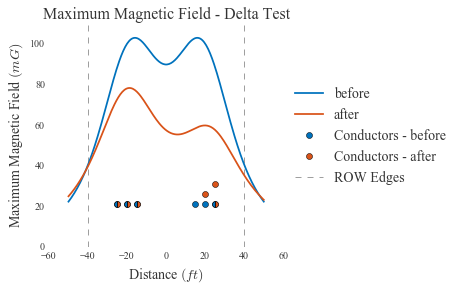

In [13]:
#the return_figs kw must be set to True, otherwise figures are closed
#automatically to avoid matplotlib memory warnings
#also, the E kw is set to False so that we only get magnetic field plots
figs = fld.plot_groups(sb, return_figs=True, E=False)
fld.show()

It's clear from the plot that switching to a "delta" configuration reduces fields throughout the ROW. We can inspect the actual values of electric and magnetic fields at the ROW edges, at a glance, with the SectionBook's `ROW_edge_max` property.

In [14]:
print(sb.ROW_edge_max)

            Bmaxl      Bmaxr     Emaxl     Emaxr
before  40.542720  40.542720  2.685421  2.573409
after   39.829126  35.332244  2.640528  2.167896


Fields are significantly reduced on the right side of the ROW, and slightly reduced on the left side because it's farther from the second circuit. If we want to try and reduce fields even further, we can see if it's possible to reduce them by swapping the positions of the phases in each circuit.

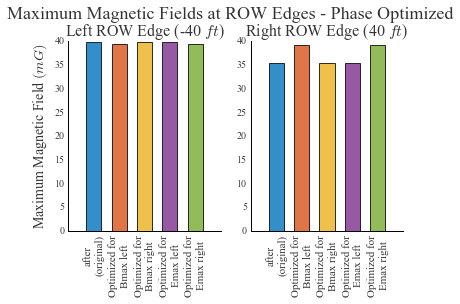

In [15]:
res, opt = fld.optimize_phasing(sb['after'], 'all')

#look at whether a phasing configuration yields a significant reduction
#in magnetic fields
fld.plot_groups_at_ROW(opt, return_figs=True, E=False)
fld.show()

Looks like phase optimization of the "after" CrossSection wouldn't reduce the fields because the circuits are already in one of potentially many optimal arrangements. Let's just check the numbers.

In [16]:
print(opt.ROW_edge_max)

                              Bmaxl      Bmaxr     Emaxl     Emaxr
after (original)          39.829126  35.332244  2.640528  2.167896
Optimized for Bmax left   39.380491  39.247289  2.648159  2.106551
Optimized for Bmax right  39.829126  35.332244  2.640528  2.167896
Optimized for Emax left   39.829126  35.332244  2.640528  2.167896
Optimized for Emax right  39.380491  39.247289  2.648159  2.106551


As a last resort, we're asked how much higher we would have to raise the second circuit, the "delta", to get magnetic fields at the right ROW edge down to 30 mG. We can use `fld.target_fields()`.

(None, 2.209329977631569, None, None)


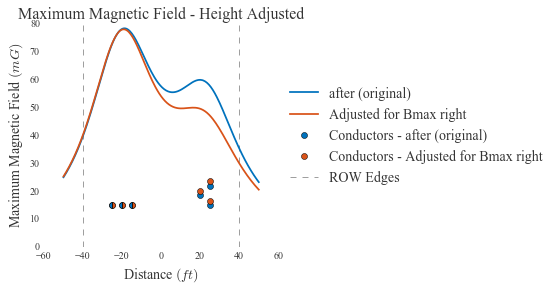

In [17]:
h, adj = fld.target_fields(sb['after'], ['2a', '2b', '2c'], 0, 30, 0, 0)
print(h)
figs = fld.plot_groups(adj, return_figs=True, E=False)
fld.show()

We would only have to raise circuit 2 an extra 2.2 feet to get predicted magnetic field values at the right ROW edge down to 30 mG. That's good info. We can export the original modeling results and the height adjusted results to excel files for reference, and be done with it.

In [18]:
sb.export()
h, adj = fld.target_fields(sb['after'], ['2a', '2b', '2c'],
                            0, 30, 0, 0, save=True)

Full SectionBook results written to: delta-test-all_results.xlsx
Maximum fields at ROW edges written to: delta-test-ROW_edge_results.csv
Height adjustment results written to: after_height_adjustments.xlsx
